# Online Hard Example Mining

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [28]:
class MLP(nn.Module):
    """
    a simple MLP with two hidden layers
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [54]:
class CustomDataLoader:
    """
    A custom data loader that subsamples the mini-batch based on high error. The MSELoss is used as 
    the loss function since this is a regression problem. The error is computed for each example in
    the mini-batch using the loss, the examples are sorted based on the error, and a subset of 
    examples with high error is selected. The subsample_fraction hyperparameter determines the 
    fraction of examples to keep.
    """
    def __init__(self, dataset, batch_size, subsample_fraction):
        """
        Args:
        - dataset: a PyTorch Dataset object
        - batch_size: an integer indicating the batch size
        - subsample_fraction: a float between 0 and 1 indicating the fraction of examples to use for 
            backpropagation
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.subsample_fraction = subsample_fraction
        
    def __iter__(self):
        """
        Returns an iterator that generates subsampled minibatches from the dataset.
        """
        indices = torch.randperm(len(self.dataset))
        
        # Iterates over the dataset and generates mini-batches starting from the index start to 
        # end, where start and end are defined by the batch size and the length of the dataset. 
        # The inputs and targets of the mini-batch are extracted from the dataset using 
        # the indices generated by indices[start:end].
        for start in range(0, len(self.dataset), self.batch_size):
            end = min(start + self.batch_size, len(self.dataset))
            inputs, targets = self.dataset[indices[start:end]]

            # torch.no_grad() used to turn off autograd for the duration of a block of code.
            with torch.no_grad():
                
                # Forward pass to obtain outputs and compute loss
                outputs = model(inputs)
                # calculate squared error
                batch_loss = np.square(outputs - targets).numpy()
                    
                # get the index of the errors based on their size. Order in descending order
                # - np.argsort() returns the indices that would sort an array. 
                #   np.argsort([3, 1, 4, 2]) would return [1, 3, 0, 2]
                # - [-1:] changes order of indices to descending order of error.
                #   the result is the array of indices that correspond to the examples with the 
                #   highest errors in the current minibatch
                sorted_idx = np.argsort(batch_loss, axis=0)[::-1]
                #print(sorted_idx)
                
                # the mini batch is subsampled where the probability of an example getting picked 
                # corresponds to the index value stored in subset_idx. values that have a high batch 
                # loss will have a high probability of being sampled since the indices are sorted in 
                # descending order based on the loss values.
                
                # select the top subset_fraction fraction of indices
                subset_size = int(len(sorted_idx) * self.subsample_fraction)
                subset_idx = sorted_idx[:subset_size]
                
                # calculate probabilities for each index based on its rank
                rank = torch.arange(subset_size, dtype=torch.float).unsqueeze(1)
                probs = rank / torch.sum(rank)
                probs = probs.reshape(-1)  # reshape to 1D tensor

                # sample indices from the distribution of probabilities
                sample_idx = torch.multinomial(probs, self.batch_size, replacement=True)
                subset_idx = subset_idx[sample_idx]
                
                # sort the sampled indices to match the order of the sorted errors
                subset_idx = sorted(subset_idx)

            # Yield subsampled inputs and targets
            yield inputs[subset_idx], targets[subset_idx]

In [55]:
# Set up the model
model = MLP(input_size=10, hidden_size=64, output_size=1)

# A randomly generated dataset is used for demonstration purposes, where each example has 10 features
# and 1 target value.In total, there are 1000 sampleswith the input shape of (1000, 10) and a target 
# variable with shape (1000, 1). 
train_dataset = torch.utils.data.TensorDataset(torch.randn(1000, 10), torch.randn(1000, 1))

In [56]:
def train_object(train_dataset, batch_size, subsample_fraction, lr, epochs):
    """
    Trains a simple multi-layer perceptron (MLP) on a given dataset using Online Hard Example Mining
    and the stochastic gradient descent (SGD) optimizer.

    Args:
    - train_dataset: torch.utils.data.Dataset object, training dataset.
    - batch_size: int, mini-batch size.
    - subsample_fraction: float between 0 and 1, fraction of hard examples to use during each training iteration.
    - lr: float, learning rate of the SGD optimizer.
    - epochs: int, number of epochs to train the model for.

    Returns:
    - train_losses_epoch: list of floats, average training loss per epoch.

    """
    
    # Set up the model
    model = MLP(input_size=10, hidden_size=64, output_size=1)
    
    # Create a custom data loader object (train_loader) based on the CustomDataLoader class 
    # defined earlier. The train_loader object is initialized with the train_dataset object created in 
    # the previous line, a batch size of 32, and a subsample fraction of 0.5. This means that each 
    # minibatch will consist of 32 examples, and during each training iteration, only the top 50% of 
    # examples with the highest errors will be used for backpropagation.
    train_loader = CustomDataLoader(train_dataset, batch_size, subsample_fraction)

    # Creates a stochastic gradient descent (SGD) optimizer object that will be used to update the model 
    # parameters during training. 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Initialize lists to store training loss and validation loss
    train_losses_epoch = []

    # Train the model
    for epoch in range(epochs):
        # Initialize lists to store training loss and validation loss
        train_losses_batch = []    
        # generate sub-sampled mini batches of hard examples
        for inputs, targets in train_loader:
            # print(inputs.shape)
            # Sets the gradients of all optimized torch.Tensor s to zero.
            optimizer.zero_grad()

            # Forward pass mini batch
            outputs = model(inputs)
            # print(outputs.shape)

            # Calculate MSE loss
            loss = nn.MSELoss()(outputs, targets)

            # Back propagate
            loss.backward()

            # Update parameters
            optimizer.step()

            # Append training loss to list
            train_losses_batch.append(loss.item())

        # Append the average loss per batch to list of loss per epoch
        train_losses_epoch.append(sum(train_losses_batch) / len(train_losses_batch))
        print(f"Epoch {epoch+1}: train_loss = {train_losses_epoch[-1]:.4f}")
    return train_losses_epoch

In [57]:
# A randomly generated dataset is used for demonstration purposes, where each example has 10 features
# and 1 target value.In total, there are 1000 sampleswith the input shape of (1000, 10) and a target 
# variable with shape (1000, 1). 
train_dataset = torch.utils.data.TensorDataset(torch.randn(1000, 10), torch.randn(1000, 1))

train_losses_epoch = train_object(train_dataset, batch_size = 32,
                                  subsample_fraction = 0.5, lr = 0.1, epochs = 100)

<ipython-input-54-8d826c5908e3>:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  yield inputs[subset_idx], targets[subset_idx]


Epoch 1: train_loss = 1.0612
Epoch 2: train_loss = 1.1031
Epoch 3: train_loss = 1.0980
Epoch 4: train_loss = 1.0757
Epoch 5: train_loss = 1.0593
Epoch 6: train_loss = 1.0669
Epoch 7: train_loss = 0.9891
Epoch 8: train_loss = 1.0458
Epoch 9: train_loss = 1.0685
Epoch 10: train_loss = 0.9970
Epoch 11: train_loss = 0.9503
Epoch 12: train_loss = 0.9603
Epoch 13: train_loss = 0.9728
Epoch 14: train_loss = 0.9546
Epoch 15: train_loss = 0.9549
Epoch 16: train_loss = 0.9903
Epoch 17: train_loss = 1.0021
Epoch 18: train_loss = 0.9458
Epoch 19: train_loss = 0.9411
Epoch 20: train_loss = 0.8505
Epoch 21: train_loss = 0.8437
Epoch 22: train_loss = 0.8367
Epoch 23: train_loss = 0.7768
Epoch 24: train_loss = 0.8502
Epoch 25: train_loss = 0.8798
Epoch 26: train_loss = 0.7433
Epoch 27: train_loss = 0.7527
Epoch 28: train_loss = 0.8095
Epoch 29: train_loss = 0.8719
Epoch 30: train_loss = 0.7866
Epoch 31: train_loss = 0.7792
Epoch 32: train_loss = 0.8480
Epoch 33: train_loss = 0.7951
Epoch 34: train_los

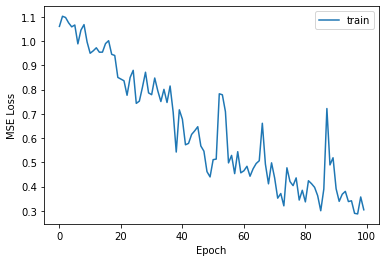

In [58]:
# Plot training and validation loss
plt.plot(train_losses_epoch, label="train")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()